In [1]:

# !pip install invisible_watermark transformers accelerate safetensors kornia
# !pip install git+https://github.com/huggingface/diffusers.git
# !pip install huggingface_hub
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(os.environ["CUDA_VISIBLE_DEVICES"])

1


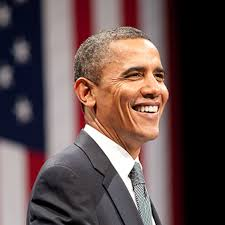

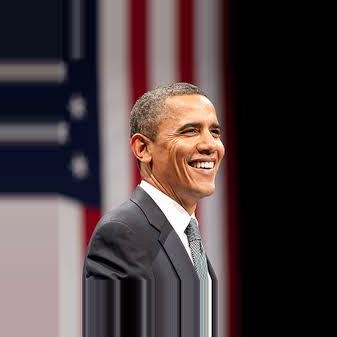

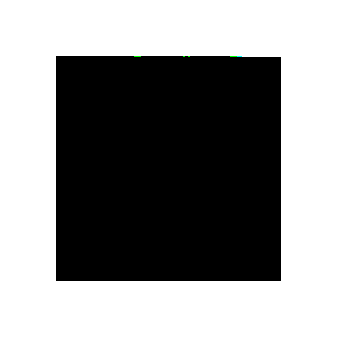

(225, 225)
(337, 337)
(337, 337)
[56, 56]


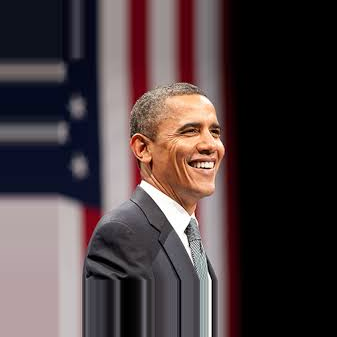

In [23]:

import torch
from torchvision.transforms import ToTensor, ToPILImage
from kornia.geometry.transform import get_affine_matrix2d, warp_affine


# Zooms out of a given image, and creates an outpainting mask for the external area.
def create_outpainting_image_and_mask(image, zoom):
    # 注意这里的zoom 是 扩大的比例, 如150% 
    # if zoom is not List
    if isinstance(zoom, list):
        new_h = int(image.size[1] * zoom[0])
        new_w = int(image.size[0] * zoom[1])
        # zoom = torch.tensor([1/zoom[0], 1/zoom[1]]).unsqueeze(0)
    elif isinstance(zoom, float):
        new_h = int(image.size[1] * zoom)
        new_w = int(image.size[0] * zoom)
        # zoom = torch.tensor([1/zoom, 1/zoom]).unsqueeze(0)
    else:
        assert False, "zoom should be a float or a list of two floats"
    image_tensor = ToTensor()(image).unsqueeze(0)
    _, c, h, w = image_tensor.shape

    center = torch.tensor((0., 0.)).unsqueeze(0)
    # move to the center
    translate = torch.tensor([new_w/2 - w/2, new_h/2 - h/2]).unsqueeze(0)
    angle = torch.tensor([0.0])
    zoom = torch.tensor([1., 1.]).unsqueeze(0)

    M = get_affine_matrix2d(
        center=center, translations=translate, angle=angle, scale=torch.tensor([1., 1.]).unsqueeze(0)
    )

    mask_image_tensor = warp_affine(
        image_tensor,
        M=M[:, :2],
        dsize=(new_h, new_w),
        padding_mode="fill",
        fill_value=-1*torch.ones(3),
    )
    mask = torch.where(mask_image_tensor < 0, 1.0, 0.0)

    transformed_image_tensor = warp_affine(
        image_tensor,
        M=M[:, :2],
        dsize=(new_h, new_w),
        padding_mode="border"
    )

    output_mask = ToPILImage()(mask[0])
    output_image = ToPILImage()(transformed_image_tensor[0])

    return output_image, output_mask, translate

import PIL
from diffusers.utils import load_image

init_image = load_image("images/face7.jpeg")

# init_image = init_image.resize((512, 512))
conditioning_image, outpaint_mask, translate = create_outpainting_image_and_mask(init_image, 1.5)
init_image.show()
conditioning_image.show()
outpaint_mask.show()
print(init_image.size)
print(conditioning_image.size)
print(outpaint_mask.size)
# paste the conditioning image on the original image
print(list(translate.squeeze(0).to(torch.int).numpy()))
conditioning_image.paste(init_image, list(translate.squeeze(0).to(torch.int).numpy()))
conditioning_image.show()

/home/t-zhiphuang/miniconda3/envs/SEED-X/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/t-zhiphuang/miniconda3/envs/SEED-X/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


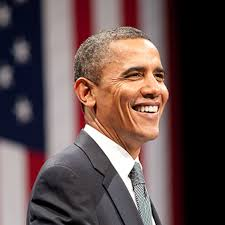

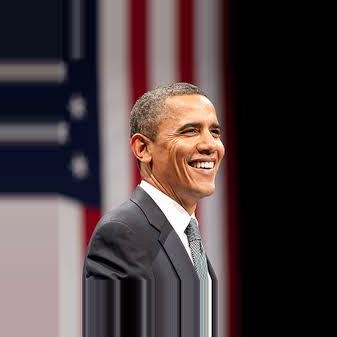

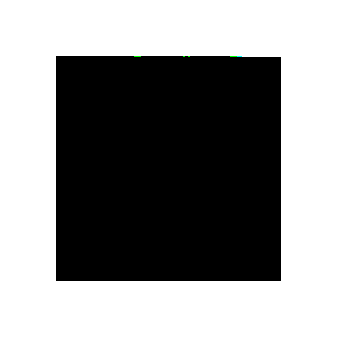

(225, 225)
(337, 337)
(337, 337)


/home/t-zhiphuang/miniconda3/envs/SEED-X/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


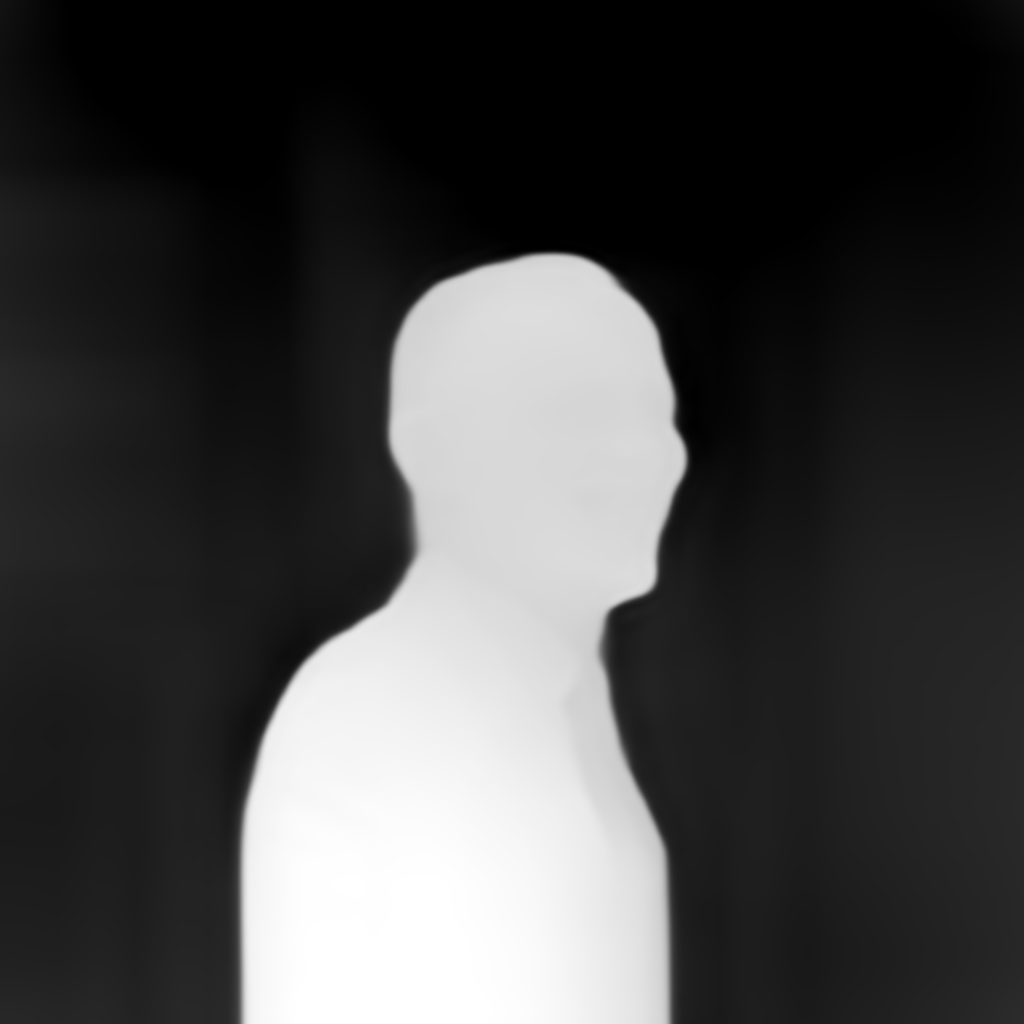

Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


NameError: name 'white_bg_image' is not defined

In [7]:
import random

import requests
import torch
from controlnet_aux import ZoeDetector
from PIL import Image, ImageOps

from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    StableDiffusionXLControlNetPipeline,
    StableDiffusionXLInpaintPipeline,
)



import PIL
from diffusers.utils import load_image

original_image = Image.open("images/face7.jpeg").convert("RGBA")

# init_image = init_image.resize((512, 512))
conditioning_image, outpaint_mask = create_outpainting_image_and_mask(init_image, 1.5)
init_image.show()
conditioning_image.show()
outpaint_mask.show()
print(init_image.size)
print(conditioning_image.size)
print(outpaint_mask.size)

zoe = ZoeDetector.from_pretrained("lllyasviel/Annotators")
image_zoe = zoe(conditioning_image, detect_resolution=512, image_resolution=1024)
image_zoe.show()

controlnets = [
    ControlNetModel.from_pretrained(
        "destitech/controlnet-inpaint-dreamer-sdxl", torch_dtype=torch.float16, variant="fp16"
    ),
    ControlNetModel.from_pretrained(
        "diffusers/controlnet-zoe-depth-sdxl-1.0", torch_dtype=torch.float16
    ),
]
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
    "SG161222/RealVisXL_V4.0", torch_dtype=torch.float16, variant="fp16", controlnet=controlnets, vae=vae
).to("cuda")

def generate_image(prompt, negative_prompt, inpaint_image, zoe_image, seed: int = None):
    if seed is None:
        seed = random.randint(0, 2**32 - 1)

    generator = torch.Generator(device="cpu").manual_seed(seed)

    image = pipeline(
        prompt,
        negative_prompt=negative_prompt,
        image=[inpaint_image, zoe_image],
        guidance_scale=6.5,
        num_inference_steps=25,
        generator=generator,
        controlnet_conditioning_scale=[0.5, 0.8],
        control_guidance_end=[0.9, 0.6],
    ).images[0]

    return image


In [8]:
prompt = "President Obama giving a speech"
negative_prompt = ""

temp_image = generate_image(prompt, negative_prompt, conditioning_image, image_zoe, 908097)
temp_image.show()



  0%|          | 0/25 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (42) must match the size of tensor b (128) at non-singleton dimension 3